<h1 style="property:value; background-color:skyblue;" align="center"> Data preparation and imputaion

In [1]:
# Basic libraries
import os
import plotly
import cufflinks
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from data_preprocessor import *
from evaluations import nrmse, evaluate
import datetime as dt
import matplotlib.pyplot as plt
import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
# from sklearn.impute import KNNImputer
warnings.filterwarnings('ignore')

# DL libraries
import numpy as np
from keras.datasets import mnist
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


### Load and prepare the data the data
- Read the txt-file as csv.
- Groupe the data by time and grid.
- Concatinate all the data in one DataFrame.
- Convevrt the full data into a numpy array, where each sample is a (100, 100) matrix.
 - Each matrix is the measurements for all grids at a spicific time step.
 - Each value in the matrix is a measurement for one grid at a this time step.

In [12]:
df = pd.read_csv('../Data/working_grids.csv', index_col=[0,1])

In [16]:
df_ = df.reset_index().groupby(['time','grid_square']).sum()

In [21]:
320/16

20.0

In [24]:
#====> Converte the data inot a numpy array
# Define the new data shape
time_steps = df.reset_index()['time'].unique()
grids = df.reset_index()['grid_square'].unique()

## Convert the pandas dataframe to a numpy array with shape()
# Each sample in the 4-D array is an image represent one snapshot taken at time-step
# to the city, each value represent the value of one grid at this time-step.
data = np.zeros(dtype=np.float64, shape=(len(time_steps), len(grids)//16, len(grids)//20, 1))

for i, j in enumerate(time_steps):
    data[i, :, :, :] = df.loc[j].to_numpy().reshape(20, 16, 1)

In [27]:
np.save('working_data.npy', data)

In [ ]:
np.load)

### Show some example of the data

In [4]:
def data_preprocessor(data, x_dim, y_dim, miss_rate=None):
    '''
    Preprocess the data before imputaion or forecasting
    1) Add some noise with a ratio.
    2) Crop the data to maintaine it easier.
    '''
    samples, rows, cols, _ = data.shape
    
    startx, starty = cols//2, rows//2
    
    temp_data = np.zeros(shape=(samples, x_dim, y_dim, 1), dtype=np.float32)
    
    for s in range(samples):
        temp_data[s] = data[s][startx-x_dim//2:starty+x_dim//2, startx-x_dim//2:starty+x_dim//2, :]
        
    data_x = np.reshape(temp_data, [samples, x_dim*y_dim]).astype(np.float32)
    
    # Parameters
    no, dim = data_x.shape
    
    if miss_rate:
        # Introduce missing data
        data_m = binary_sampler(1-miss_rate, no, dim)
        miss_data_x = data_x.copy()
        miss_data_x[data_m == 0] = np.nan

        return data_x, miss_data_x, data_m
    
    else:
        return data_x

#### Line plot for some grids over time.

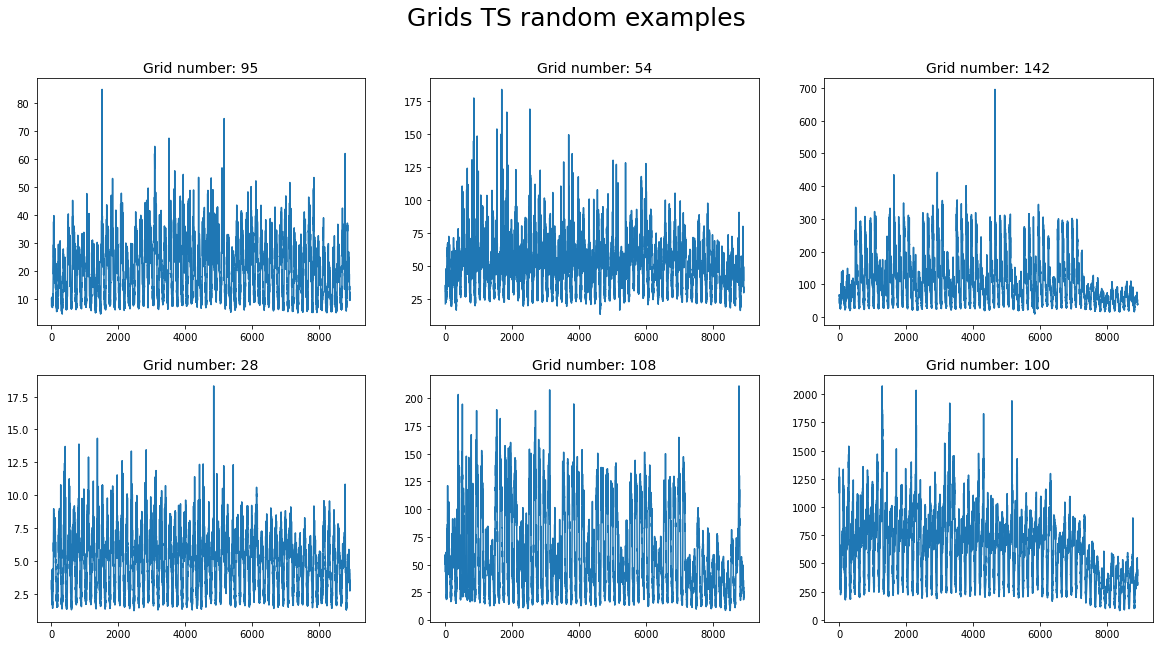

In [9]:
r, c = 2, 3
fig, axes = plt.subplots(r, c, figsize=(20,10))
fig.suptitle('Grids TS random examples', fontsize=25)

for i in range(r*c):
    x = np.random.randint(0, full_data.shape[1])
    y = np.random.randint(0, full_data.shape[2])
    axes[i//c][i%c].set_title('Grid number: %d'%int(x+y), fontsize = 14)
    ax=axes[i//c][i%c].plot(full_data[:,x,y,:]);

#### Full grids measurements at time steps.

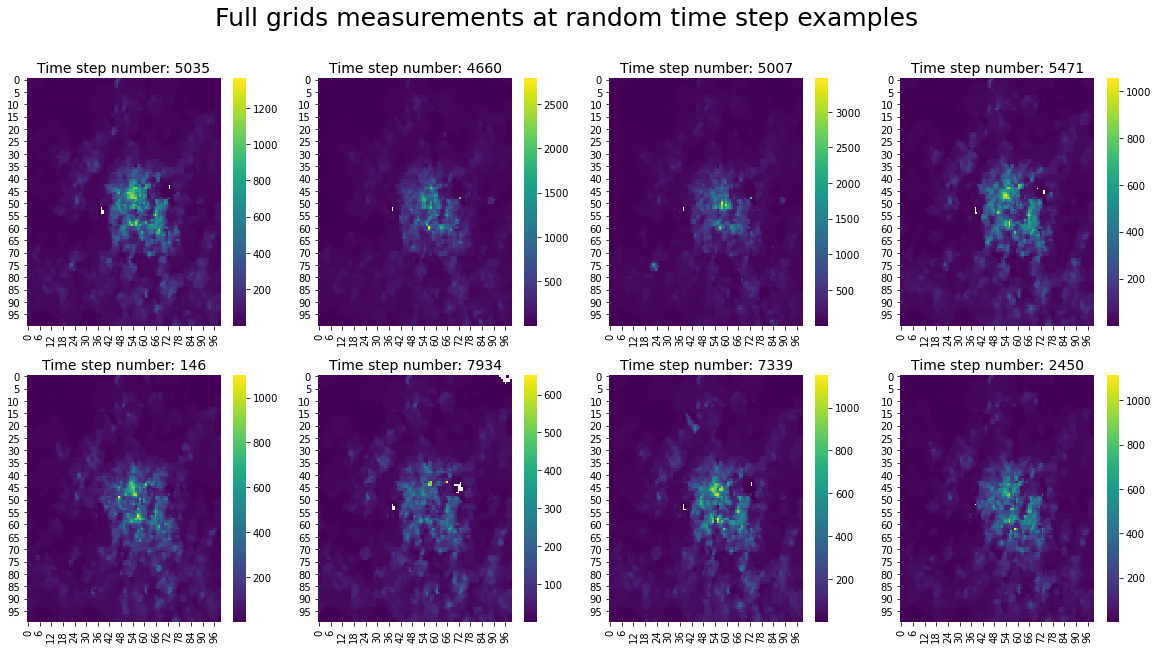

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(20,10))
fig.suptitle('Full grids measurements at random time step examples', fontsize=25)

for i in range(8):
    s = np.random.randint(0, len(full_data))
    axes[i//4][i%4].set_title('Time step number: %d'%s, fontsize = 14)
    sns.heatmap(full_data[s].reshape(100, 100), cmap='viridis', ax=axes[i//4][i%4])

#### NaN values in the data

In [10]:
nan_ratio_full = (np.isnan(full_data).sum()/len(full_data.flatten()))
print('NaN values ratio in the full data is : %f'%nan_ratio_full,'%')

NaN values ratio in the full data is : 0.000388 %


In [11]:
nan_ratio_1 = (np.isnan(month_1).sum()/len(full_data.flatten()))
print('NaN values ratio is : %f'%nan_ratio_1,'%')

NaN values ratio is : 0.000031 %


In [12]:
nan_ratio_2 = (np.isnan(month_2).sum()/len(full_data.flatten()))
print('NaN values ratio is : %f'%nan_ratio_2,'%')

NaN values ratio is : 0.000358 %


<!-- labels = ['Month 1','Month 2']

m_1 = np.array([np.isnan(month_1).sum()/len(month_1.flatten()), np.isnan(month_1).sum()/len(full_data.flatten())])
m_2 = np.array([np.isnan(month_2).sum()/len(month_2.flatten()), np.isnan(month_2).sum()/len(full_data.flatten())])

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(20, 8))
bar1 = ax.bar(x - width/2, m_1, width, label='Month ra')
bar2 = ax.bar(x + width/2, m_2, width, label='Women')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('NaNs Ratio')
ax.set_title('NaN ratio for each month')
ax.set_xticks(x, labels)
ax.legend()
ax.bar_label(bar1, padding=3)
ax.bar_label(bar2, padding=3)

fig.tight_layout()

plt.show()
 -->

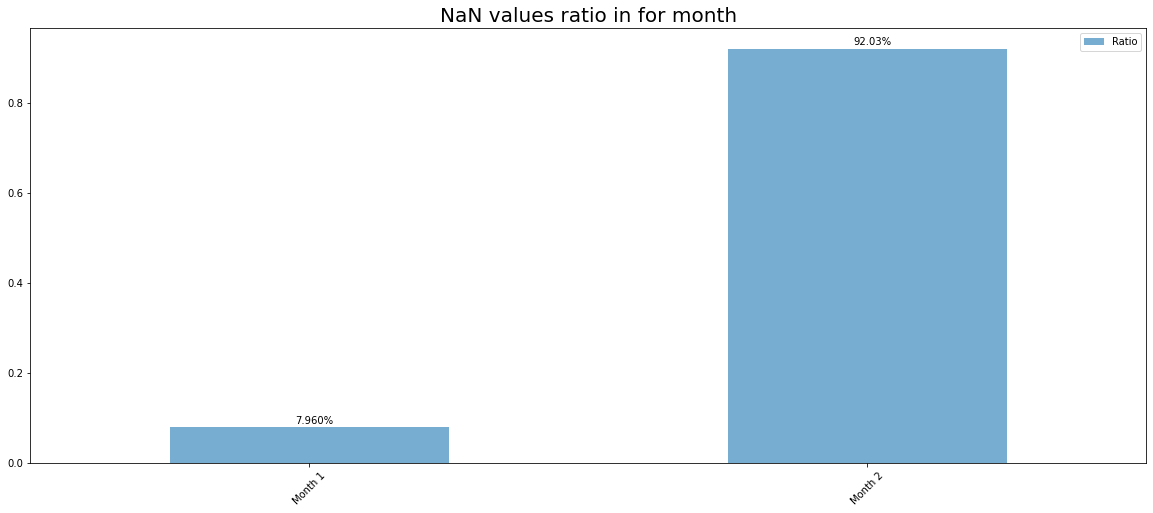

In [13]:
nan_df = pd.DataFrame({'Month 1':nan_ratio_1/nan_ratio_full, 'Month 2':nan_ratio_2/nan_ratio_full}, index=['Ratio']).T
ax = nan_df.plot(kind='bar', rot=45, alpha=0.6, figsize=(20, 8))
ax.set_title('NaN values ratio in for month', fontsize=20)
ax.annotate(str(str(ax.patches[0].get_height()*100)[:5]+'%'), (ax.patches[0].get_x()* 0.1, ax.patches[0].get_height()* 1.1))
ax.annotate(str(str(ax.patches[1].get_height()*100)[:5]+'%'), (ax.patches[1].get_x()* 1.3, ax.patches[1].get_height()* 1.01));

><b>Most of Null values in month 2. (92%)<br>
    We can work with month 1 to be able to evaluate our results.
    
> #### I will work with the month one data and neglect this small ratio, then compare the performace of each imputation model with:
> - 5%
> - 10%
> - 15%
> - 20%)

### Missing data imputation models
- We have several methodes to impute time series data 
    - Conventional methods:
        - Ignore or deletion.
        - Mean imputaion.
        - Mode imputaion.
        - Median imputaion.
    - Imputation procedure:
        - Last valid observation forward.
        - Next valid observation forward.
        - MICE or Multiple Imputation by Chained Equation.
    - Learnable methods:
        - KNN algorithm.
        - AutoRegressive.
        - Genitic algorithm.
        - MICE algorithm.
        - Least square SVM.
        - GAIN.
        - Conv-GAIN.

### Conventional methods

In [96]:
def evaluation(data_x:np.ndarray, miss_data_x:np.ndarray, data_m:np.ndarray, method:str, n_neighbors=2, max_iter=1):
    
    def fillnan_eval(real:np.ndarray, with_nan:np.ndarray, mask:np.ndarray, method:str, metrics=('rmse','nrmse')):
        """ Filling NaN values with mean, mode, or median """
        
        # ignore the original NaNs
        with_nan = with_nan[np.argwhere(~np.isnan(real))].flatten()
        mask = mask[np.argwhere(~np.isnan(real))].flatten()
        real = real[np.argwhere(~np.isnan(real))].flatten()
        
        # calculate mean, mode, or median for the values
        temp = with_nan[np.argwhere(~np.isnan(with_nan))]
        
        # choose the imputaion method
        if method.lower()=='mean':
            value = np.mean(temp)
            imputed = pd.Series(with_nan).fillna(value)

        elif method.lower()=='mode':
            value = np.array(stats.mode(temp)[0])[0][0]
            imputed = pd.Series(with_nan).fillna(value)
        
        elif method.lower()=='median':
            value = np.nanmedian(temp)
            imputed = pd.Series(with_nan).fillna(value)
        
        elif method.lower()=='lvo':
            imputed = pd.Series(with_nan).fillna(method='ffill')

        elif method.lower()=='nvo':
            imputed = pd.Series(with_nan).fillna(method='bfill')

        return real, with_nan, mask, imputed
    
    if method.lower() in ['mean','mode','median','lvo','nvo']:
        # store the results
        results = {'nrmse':0}
        # iterate over the data
        for i in range(0, data_x.shape[1]):
            for j in range(0, data_x.shape[2]):
                real, with_nan, mask, imputed = fillnan_eval(data_x[:,i,j], miss_data_x[:,i,j], data_m[:,i,j], method)
                results['nrmse'] += nrmse(real, imputed, mask)/len(imputed*(1-mask))
        
    elif method.lower()=='mice':
        # store the results
        results = 0
        # Convert the data into multivariate
        miss_x = pd.DataFrame()
        real_x = pd.DataFrame()
        for i in range(data_x.shape[1]):
            for j in range(data_x.shape[2]):
                miss_x[i*j] = pd.Series(miss_data_x[:,i,j].flatten())
                real_x = data_x[:,i,j].flatten()
                mask = data_m[:,i,j].flatten()
                # define imputer
                lr = LinearRegression()
                imp = IterativeImputer(estimator=lr,missing_values=np.nan, 
                                       max_iter=max_iter, verbose=0, imputation_order='ascending')
                # fit on the dataset and transform
                imputed = imp.fit_transform(miss_x).flatten()
                results += nrmse(real_x, imputed, mask)/len(imputed*(1-mask))
            return results
    elif method.lower()=='knn':
        results = {'nrmse':0}
        # define the data
        for i in range(0, data_x.shape[1]):
            for j in range(0, data_x.shape[2]):
                real, with_nan, mask = data_x[:,i,j], miss_data_x[:,i,j], data_m[:,i,j]
                # define imputer                
                imputer = KNNImputer(n_neighbors=n_neighbors, weights='uniform', metric='nan_euclidean')
                # fit on the dataset and transform
                imputed = imputer.fit_transform(with_nan.reshape(-1, 1))
                results['nrmse'] += nrmse(real, imputed, mask)/len(imputed*(1-mask))
                
        return results

    else:
        raise(Exception('Only  mean, mode, median, LVO, NVO, mice and knn'))
        
    return results

In [10]:
# We will deal with a reduced version of the data.
na_1 = np.isnan(month_1).sum()
na_2 = np.isnan(data_preprocessor(month_1, 40, 40)).sum()
print('NaN values in month 1: {}\nNan values in reduced version: {}'.format(na_1, na_2))

NaN values in month 1: 2761
Nan values in reduced version: 2069


><b>The (40, 40) verson still has the most of nan value and also can be maintained easier by many algorithms to make comparison.

#### Mean

In [94]:
Mean_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}

for ratio in Mean_Results.keys():
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor(month_1, miss_rate, 40, 40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    Mean_Results[ratio] = {ratio: value for ratio, value in evaluation(data_x, miss_data_x, data_m, 'mean').items()}

In [95]:
Mean_Results = pd.DataFrame(Mean_Results).T
Mean_Results

,nrmse
5%,0.012981
10%,0.018304
15%,0.022452
20%,0.025937
25%,0.029000


rate
time                grid_num           
2013-11-01 00:00:00 1         11.621593
                    2         11.647701
                    3         11.675491
                    4         11.545972
                    5         10.479600
...                                 ...
                    96        13.185229
                    97        13.185229
                    98        13.188508
                    99        13.185229
                    100       13.183933

[100 rows x 1 columns]

#### Mode

In [97]:
Mode_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}

for ratio in Mode_Results.keys():
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor(month_1, miss_rate, 40, 40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    Mode_Results[ratio] = {ratio: value for ratio, value in evaluation(data_x, miss_data_x, data_m, 'mode').items()}

In [98]:
Mode_Results = pd.DataFrame(Mode_Results).T
Mode_Results

,nrmse
5%,0.021147
10%,0.030116
15%,0.037348
20%,0.043679
25%,0.049396


#### Median

In [99]:
Median_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}

for ratio in Median_Results.keys():
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor(month_1, miss_rate, 40, 40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    Median_Results[ratio] = {ratio: value for ratio, value in evaluation(data_x, miss_data_x, data_m, 'median').items()}

In [100]:
Median_Results = pd.DataFrame(Median_Results).T
Median_Results

,nrmse
5%,0.013290
10%,0.018837
15%,0.023061
20%,0.026616
25%,0.029743


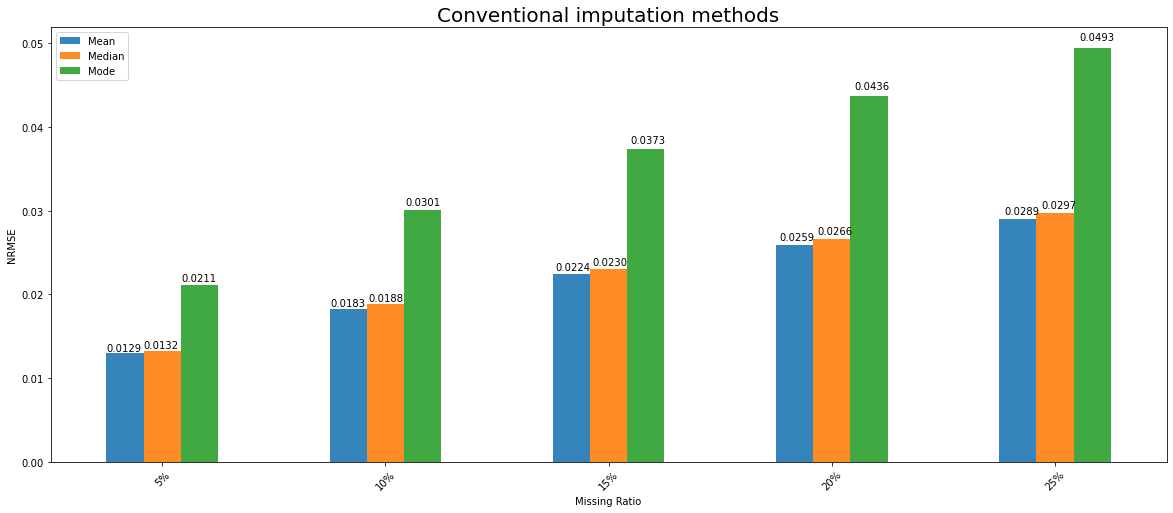

In [101]:
# Concatenate all results in one dataframe
full_conven_results = Mean_Results.rename(columns={'nrmse':'Mean'})
full_conven_results['Median'] = Median_Results
full_conven_results['Mode'] = Mode_Results

ax = full_conven_results.plot(kind='bar', rot=45, alpha=0.9, figsize=(20,8))
ax.set_title('Conventional imputation methods', fontsize=20)
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');
for p in ax.patches:
    ax.annotate(str(str(p.get_height())[:6]), (p.get_x()* 1.006, p.get_height()* 1.02))

### Imputaion procedure

#### Last/Next valid observation

In [102]:
Lvo_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
Nvo_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}

for ratio in Lvo_Results.keys():
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor(month_1, miss_rate, 40, 40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    Lvo_Results[ratio] = evaluation(data_x, miss_data_x, data_m, 'LVO')
    Nvo_Results[ratio] = evaluation(data_x, miss_data_x, data_m, 'NVO')

Lvo_Results = pd.DataFrame(Lvo_Results).T
Nvo_Results = pd.DataFrame(Nvo_Results).T

# Concatenate all results in one dataframe
full_proc_results = Lvo_Results.rename(columns={'nrmse':'Last observation'})
full_proc_results['Next observation'] = Nvo_Results

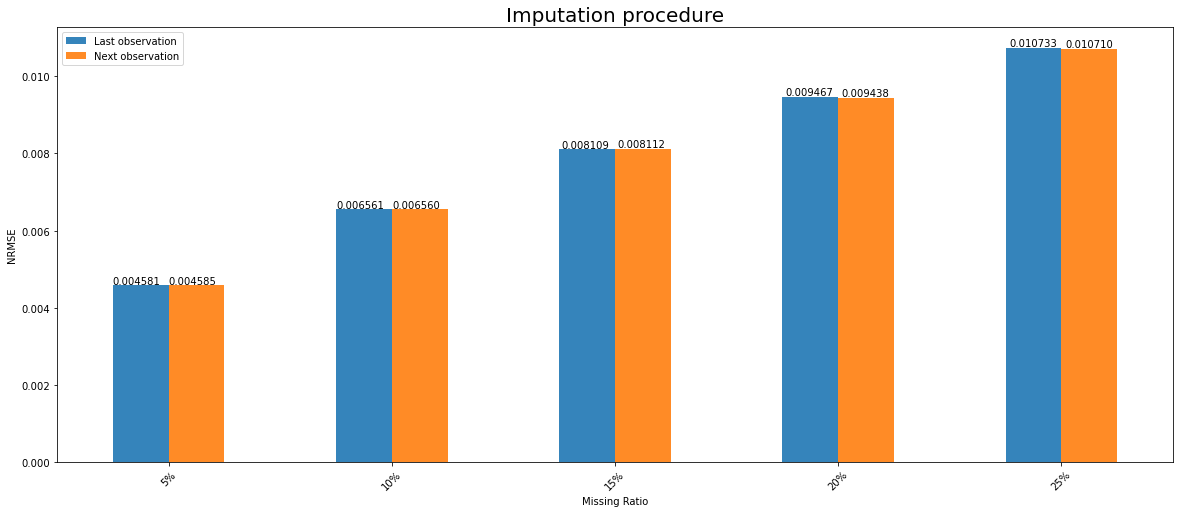

In [103]:
# Concatenate all results in one dataframe
ax = full_proc_results.plot(kind='bar', rot=45, alpha=0.9, figsize=(20,8));
ax.set_title('Imputation procedure', fontsize=20)
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');
for p in ax.patches:
    ax.annotate(str(str(p.get_height())[:8]), (p.get_x()* 1.005, p.get_height()* 1.005))

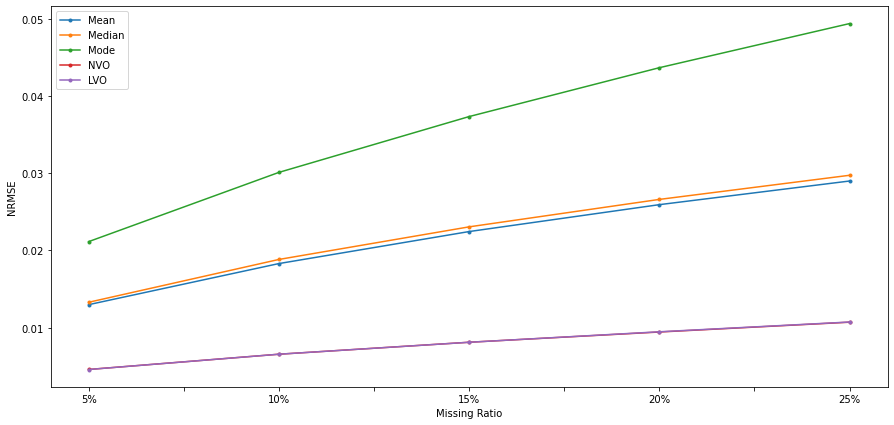

In [104]:
full_results = full_conven_results
full_results['NVO'] = Nvo_Results
full_results['LVO'] = Lvo_Results
ax = full_results.plot(kind='line', figsize=(15, 7), style='.-')
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');

### Learnable methods

#### MICE
<img src="MICE.png" height="800" width="800">

In [108]:
MICE_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}

for ratio in MICE_Results.keys():
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor(month_1, miss_rate, 40, 40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    MICE_Results[ratio] = evaluation(data_x, miss_data_x, data_m, 'mice', max_iter=2)

In [111]:
MICE_Results = pd.DataFrame(index = MICE_Results.keys(), data = MICE_Results.values()).rename(columns={0:'MICE'})
MICE_Results

,MICE
5%,0.000279
10%,0.000400
15%,0.000484
20%,0.000571
25%,0.000633


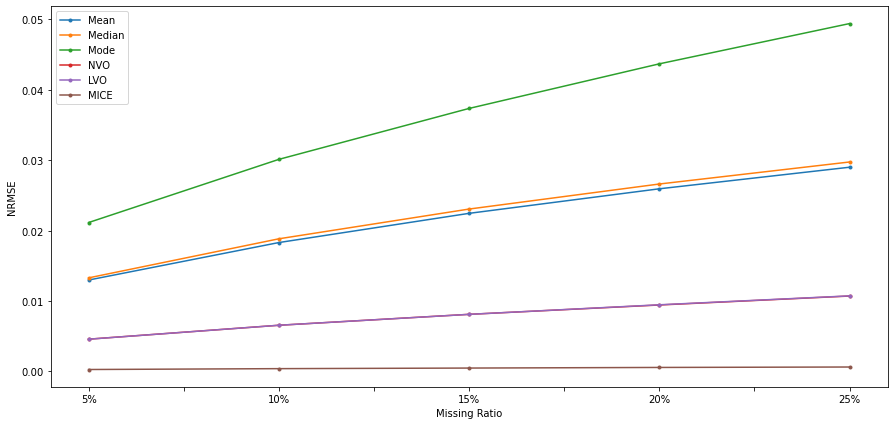

In [112]:
full_results['MICE'] = MICE_Results
ax = full_results.plot(kind='line', figsize=(15, 7), style='.-')
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');

### GAIN

In [115]:
from GAIN import GAIN
from gain_utils import *

Miss Ratio: 5%


Epoch(1): D_loss, G_loss ===> 0.199, 0.003: 100%|██████████████████████████████████████| 67/67 [00:31<00:00,  2.10it/s]


Image : 1457
nrmse :  0.028275514979884533


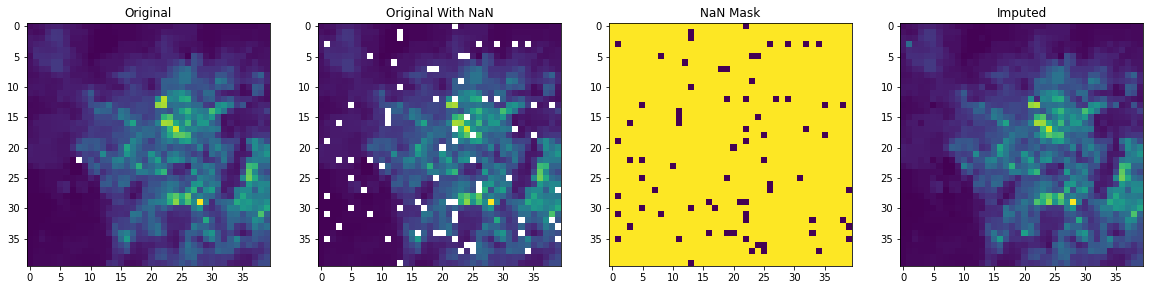

Image : 3512
nrmse :  0.010411590380519085


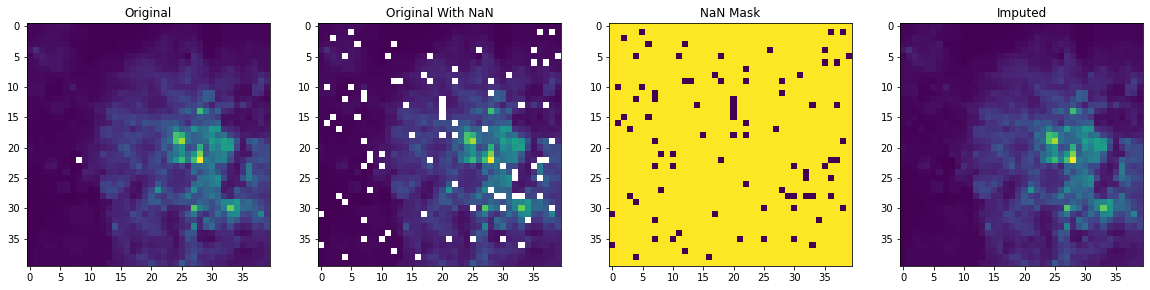

Miss Ratio: 10%


Epoch(1): D_loss, G_loss ===> 0.329, 0.011: 100%|██████████████████████████████████████| 67/67 [00:33<00:00,  1.99it/s]


Image : 1858
nrmse :  0.1276432456166844


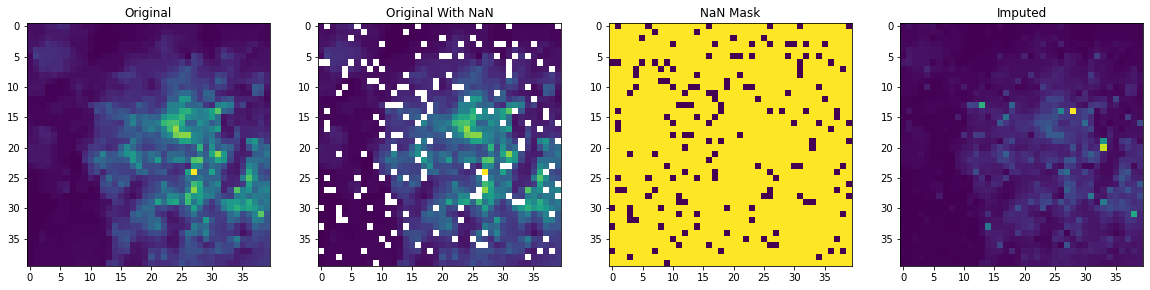

Image : 2132
nrmse :  0.06875263415577398


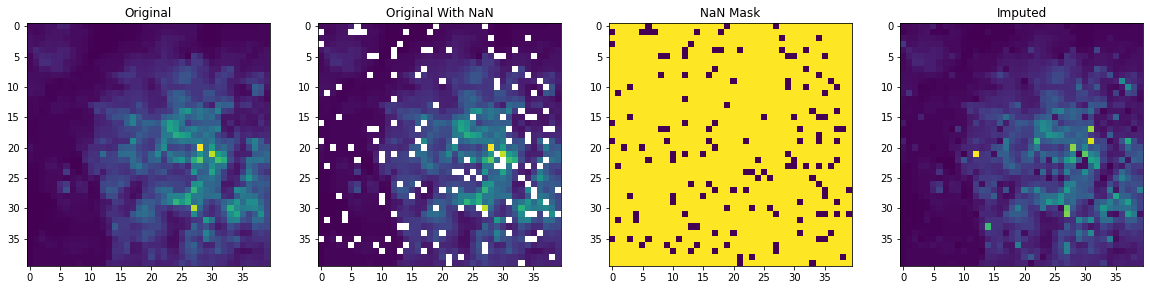

Miss Ratio: 15%


Epoch(1): D_loss, G_loss ===> 0.423, 0.025: 100%|██████████████████████████████████████| 67/67 [00:37<00:00,  1.80it/s]


Image : 721
nrmse :  0.2300706902450068


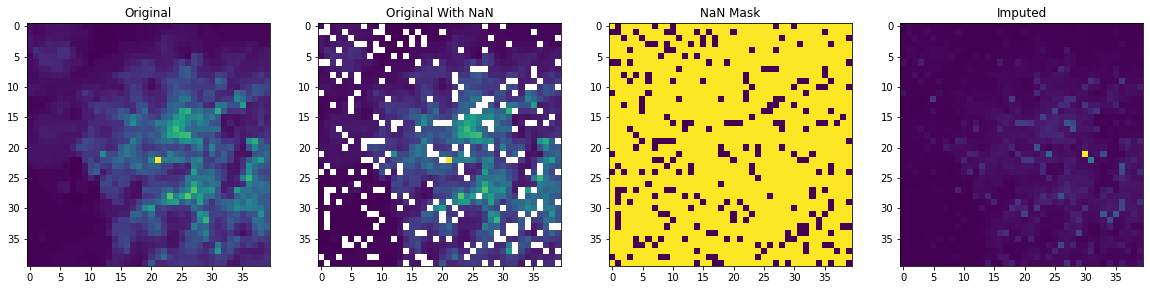

Image : 1454
nrmse :  0.4067235498999287


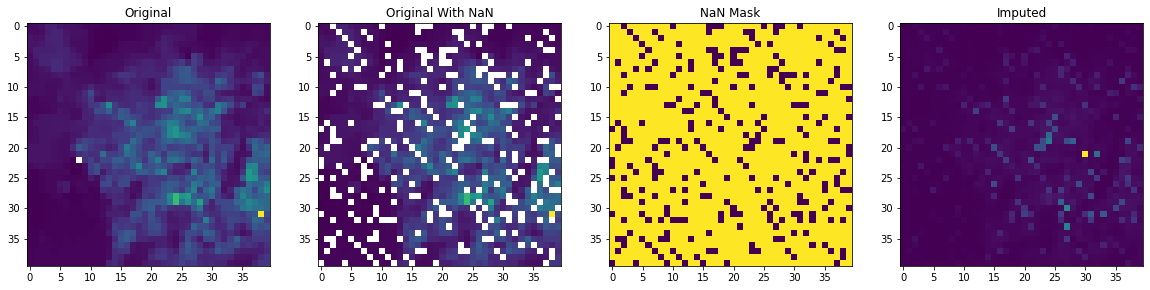

Miss Ratio: 20%


Epoch(1): D_loss, G_loss ===> 0.503, 0.046: 100%|██████████████████████████████████████| 67/67 [00:16<00:00,  4.17it/s]


Image : 2933
nrmse :  0.11586052278969845


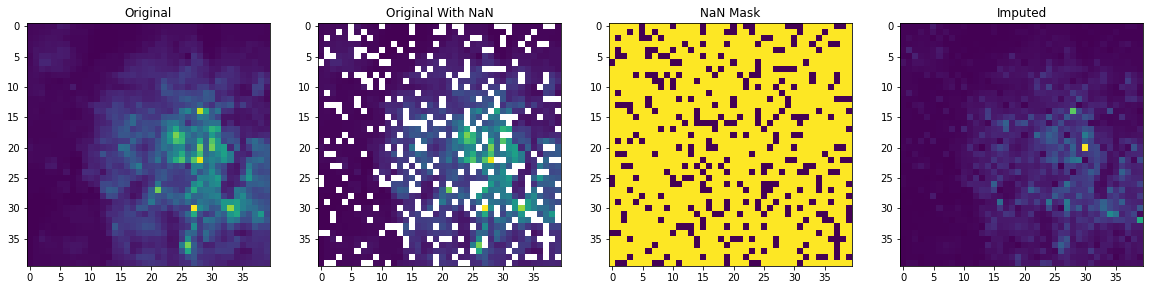

Image : 4263
nrmse :  0.0626700218060489


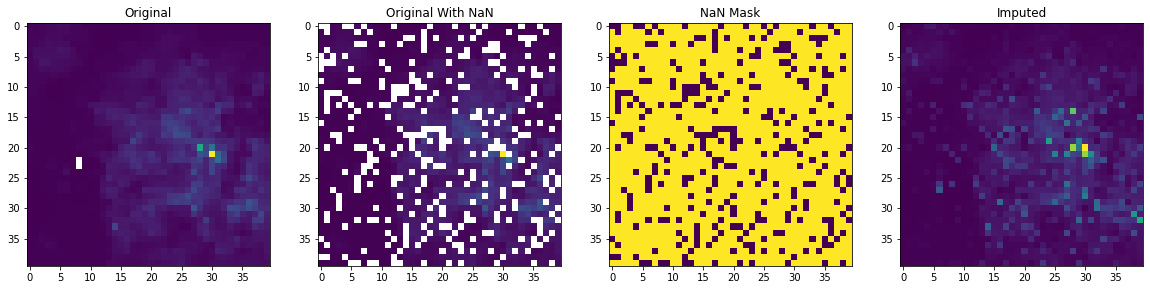

Miss Ratio: 25%


Epoch(1): D_loss, G_loss ===> 0.562, 0.076: 100%|██████████████████████████████████████| 67/67 [00:15<00:00,  4.30it/s]


Image : 1463
nrmse :  0.42369510679315386


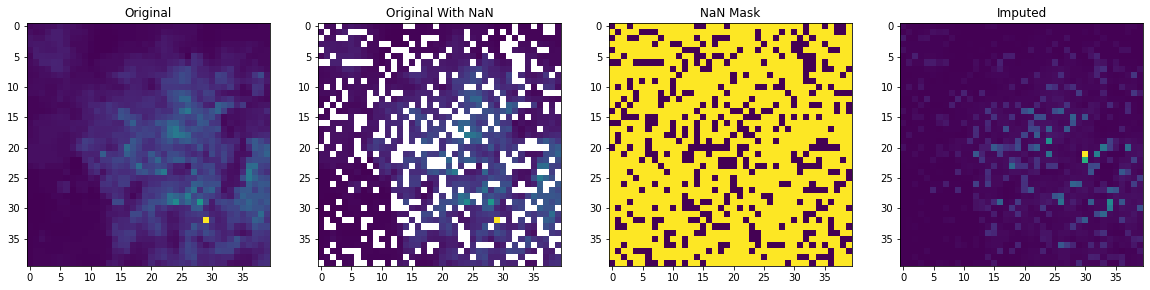

Image : 2746
nrmse :  0.35912133523177847


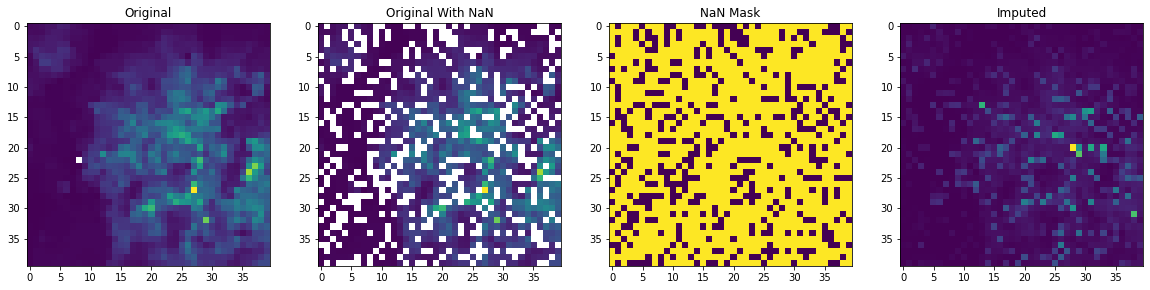

In [117]:
GAIN_Results ={'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}

for ratio in GAIN_Results.keys():
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor(month_1, miss_rate, 40, 40)
    gain_parameters = {'batch_size':64,
                       'hint_rate':0.1,
                       'learning_rate':0.001,
                       'alpha':0.005,
                       'iterations':1}
    print('Miss Ratio: %s'%ratio)
    imputed_data = GAIN(miss_data_x, gain_parameters)
    show_results(data_x, miss_data_x, data_m, imputed_data, num_examples=2, cmap='viridis')
    GAIN_Results[ratio] = evaluate(actual=data_x, predicted=imputed_data, mask=data_m, metrics=(['nrmse']))

In [118]:
pd.DataFrame(GAIN_Results).T.rename(columns={'nrmse':'Conv-GAIN'})

,Conv-GAIN
5%,0.000006
10%,0.000024
15%,0.000063
20%,0.000069
25%,0.000057


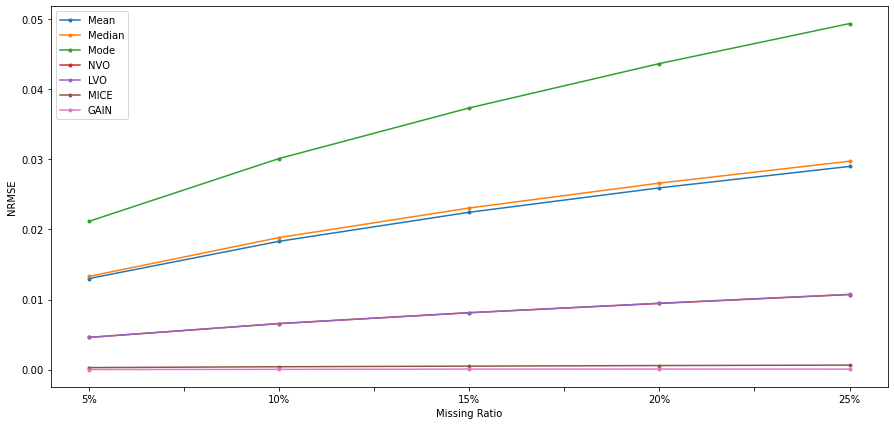

In [130]:
full_results['GAIN'] = [list(GAIN_Results.values())[v]['nrmse'] for v in range(5)]
ax = full_results.plot(kind='line', figsize=(15,7), style='.-')
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');

### Conv-GAIN

In [120]:
from Conv_GAIN import Conv_GAIN
from conv_gain_utils import *

Miss Ratio: 5%


Epoch(1): D_loss, G_loss ===> 2.024, 0.056: 100%|██████████████████████████████████████| 67/67 [02:14<00:00,  2.01s/it]


Image : 536
nrmse :  0.02364403443654008


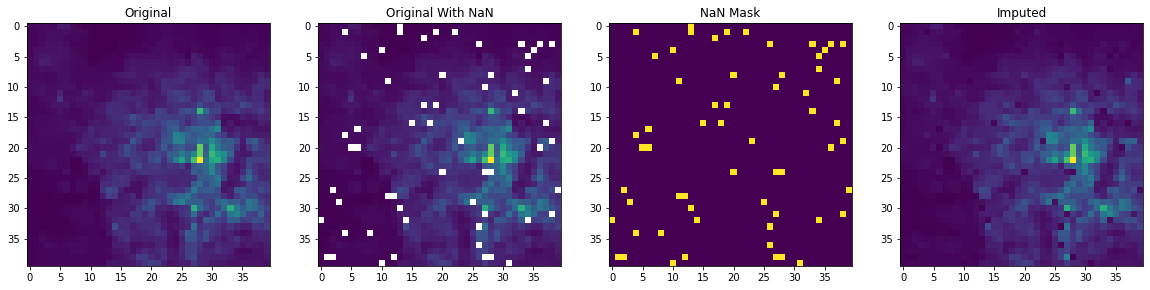

Image : 3160
nrmse :  0.059210841140047696


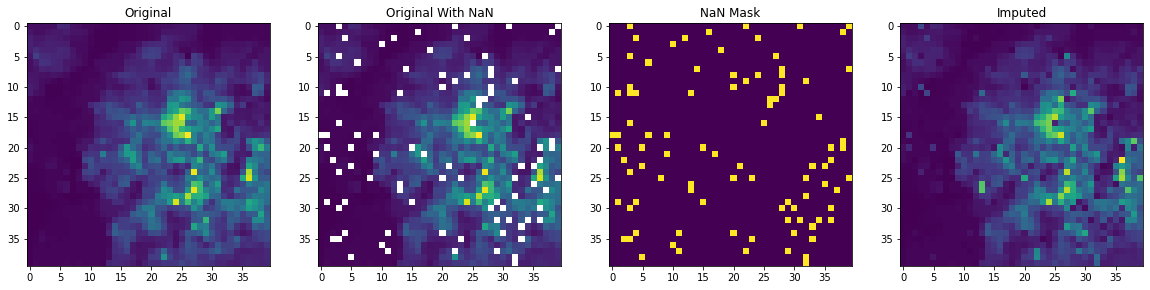

Miss Ratio: 10%


Epoch(1): D_loss, G_loss ===> 3.314, 0.184: 100%|██████████████████████████████████████| 67/67 [02:18<00:00,  2.07s/it]


Image : 821
nrmse :  0.0417293911900493


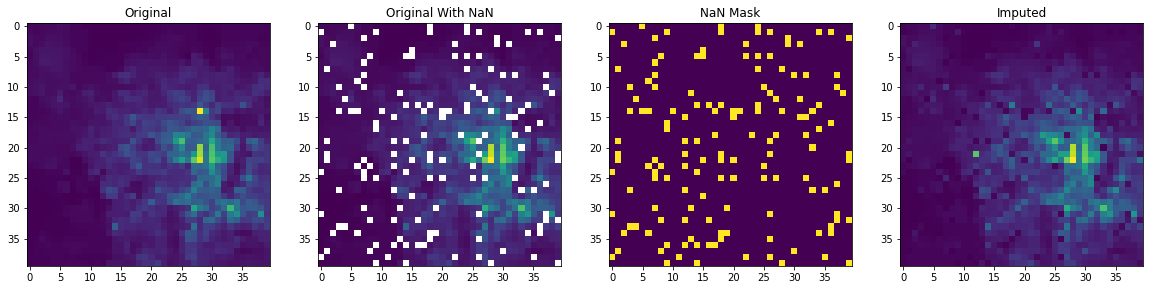

Image : 3628
nrmse :  0.4384368045216535


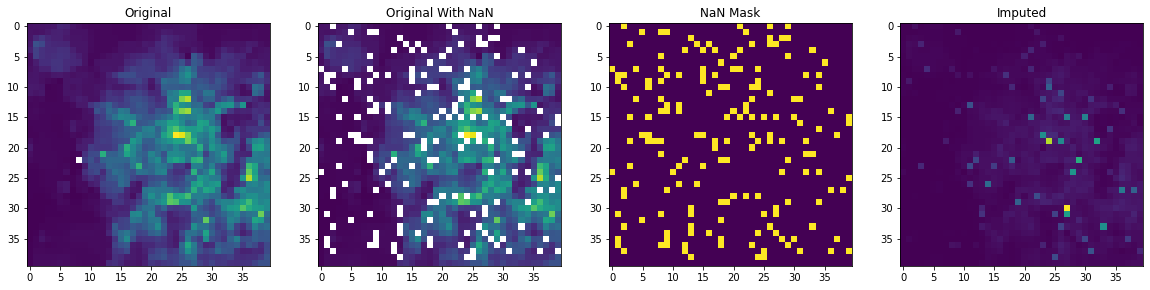

Miss Ratio: 15%


Epoch(1): D_loss, G_loss ===> 5.076, 0.477: 100%|██████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Image : 1055
nrmse :  0.15395088736783558


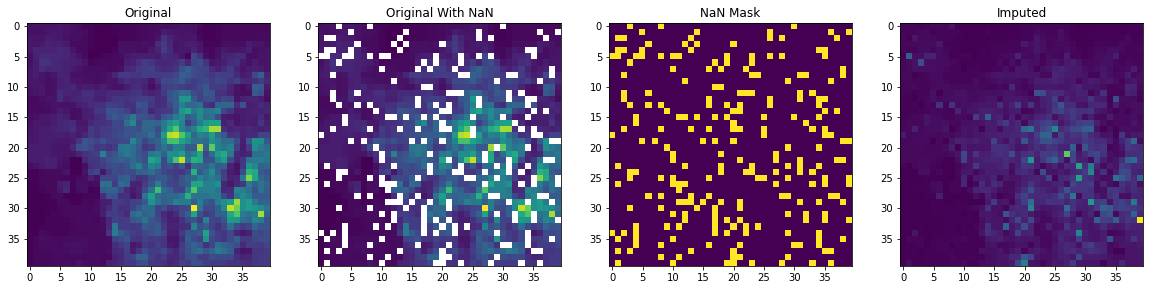

Image : 1481
nrmse :  0.5149541999637542


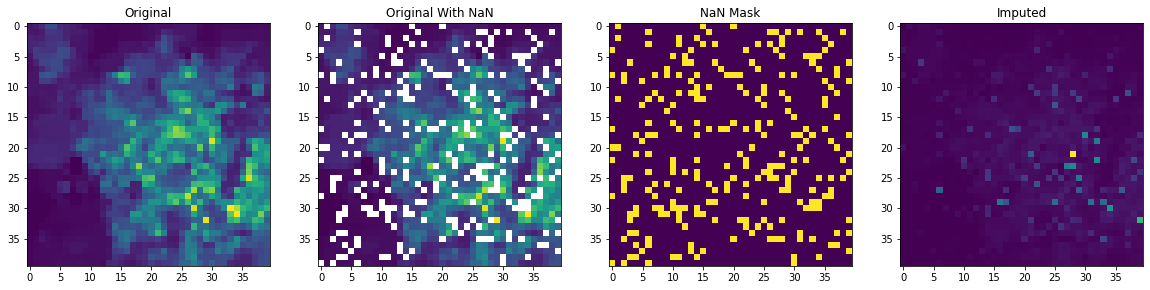

Miss Ratio: 20%


Epoch(1): D_loss, G_loss ===> 6.199, 0.850: 100%|██████████████████████████████████████| 67/67 [02:14<00:00,  2.00s/it]


Image : 955
nrmse :  0.05585928767038473


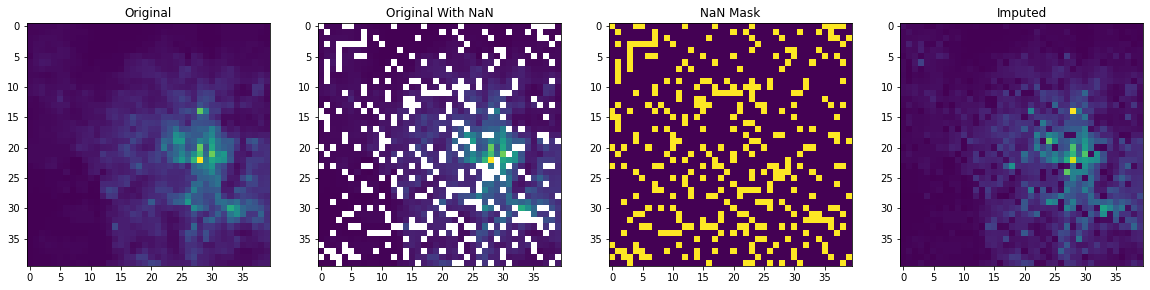

Image : 3912
nrmse :  0.2151793581224859


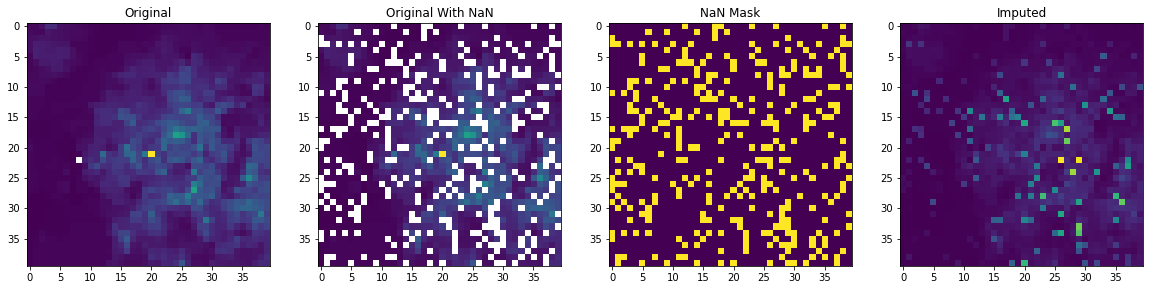

Miss Ratio: 25%


Epoch(1): D_loss, G_loss ===> 6.902, 1.122: 100%|██████████████████████████████████████| 67/67 [02:16<00:00,  2.03s/it]


Image : 3465
nrmse :  0.35602301923435764


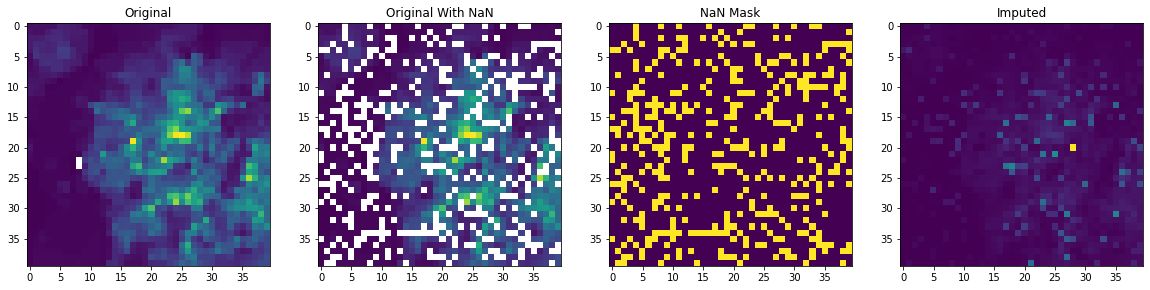

Image : 418
nrmse :  0.23723565248740744


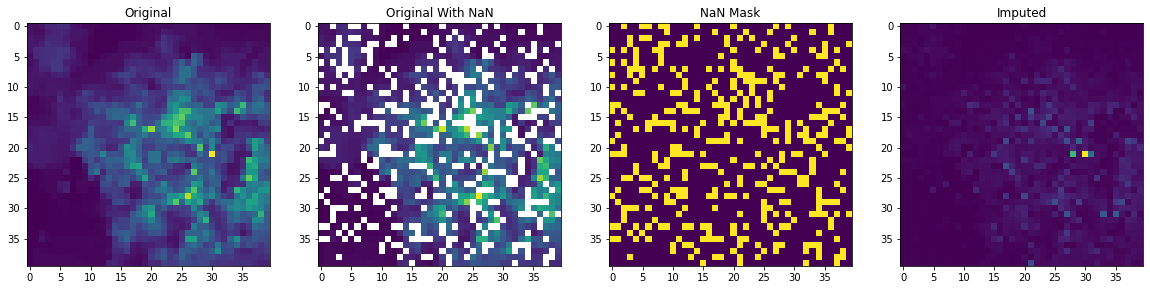

In [121]:
Conv_GAIN_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}

for ratio in Conv_GAIN_Results.keys():
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor(month_1, miss_rate, 40, 40)
    conv_gain_parameters = {'batch_size':64,
                            'hint_rate':0.1,
                            'learning_rate':0.001,
                            'alpha':0.005,
                            'iterations':1}
    print('Miss Ratio: %s'%ratio)
    imputed_data = Conv_GAIN(miss_data_x, conv_gain_parameters)
    show_results(data_x, miss_data_x, data_m, imputed_data, num_examples=2, cmap='viridis')
    Conv_GAIN_Results[ratio] = evaluate(actual=data_x, predicted=imputed_data, mask=data_m, metrics=(['nrmse']))

In [122]:
pd.DataFrame(Conv_GAIN_Results).T.rename(columns={'nrmse':'Conv-GAIN'})

,Conv-GAIN
5%,0.000019
10%,0.000037
15%,0.000051
20%,0.000049
25%,0.000041


#### GAIN vs Conv-GAIN

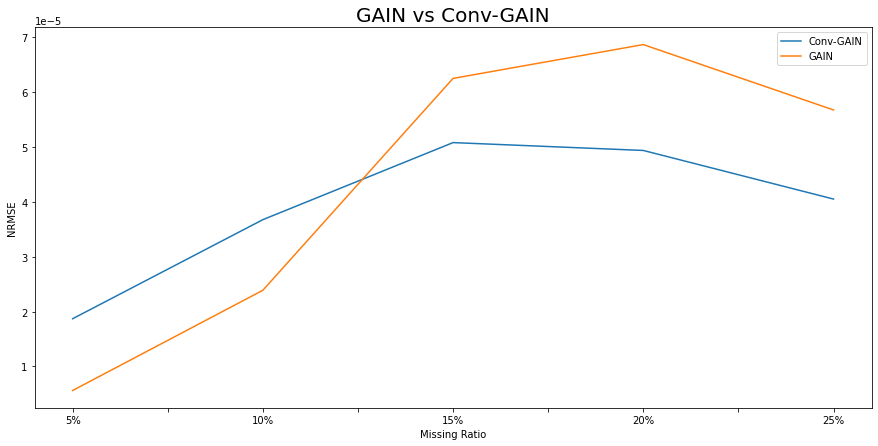

In [123]:
g_r = pd.DataFrame(Conv_GAIN_Results).T.rename(columns={'nrmse':'Conv-GAIN'})
g_r['GAIN'] = [list(GAIN_Results.values())[v]['nrmse'] for v in range(5)]
ax = g_r.plot(kind='line', figsize=(15, 7))
ax.set_title('GAIN vs Conv-GAIN', fontsize=20)
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');

#### The full results

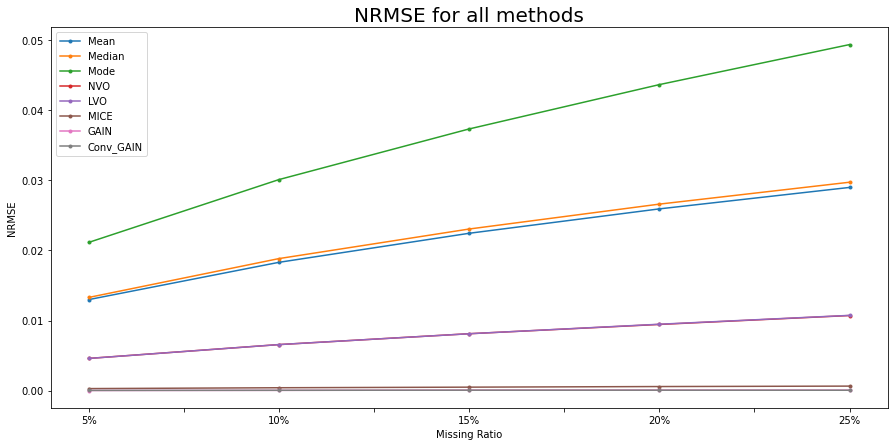

In [124]:
full_results['Conv_GAIN'] = [list(Conv_GAIN_Results.values())[v]['nrmse'] for v in range(5)]
ax = full_results.plot(kind='line', figsize=(15, 7), style='.-')
ax.set_title('NRMSE for all methods', fontsize=20)
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');

### Let's use Conv-GAIN Model to impute our data
- The shape of data is very large.
- We will apply the Conv-GAIN to the the data as a sliding window with shape (25,25) slides over the whole data.

In [266]:
def full_data_imputaion(full_data:np.ndarray, square_length:int, conv_gain_parameters:dict):
    
    # check if the full data can be divided on squares each has the shape (square_length, square_length).
    if ((full_data.shape[1]%square_length) and (full_data.shape[2]%square_length)) != 0:
        raise(Exception('Expected a square length value so that full data can be divided into number of squares all have the same square length'))
    
    # create a new imputed data
    full_data_imputed = full_data.copy()

    # iterate over the all squares ===> 16 squares each square is (25, 25) (16*25*25=100*100=10000)
    for i in range(0, 4 ,1):
        for j in range(0, 4 ,1):
            print('Square : ({}, {})'.format(i, j))
            # get the imputed data
            temp = Conv_GAIN(full_data_imputed[:, i*square_length:i*square_length+square_length,\
                                               j*square_length:j*square_length+square_length],
                             conv_gain_parameters)
            # replace the origina data with the imputed data from the model 
            full_data_imputed[:, i*square_length:i*square_length+square_length,\
                              j*square_length:j*square_length+square_length] = temp
            # show an example from each model 
            idx = np.random.randint(1, len(full_data))
            plt.figure(figsize=(10,5))
            plt.subplot(1,2,1)
            plt.subplot(1,2,1).set_title('Original', fontsize=16)
            plt.imshow(full_data[idx, i*square_length:i*square_length+square_length,\
                                 j*square_length:j*square_length+square_length])
            plt.subplot(1,2,2)
            plt.subplot(1,2,2).set_title('Imputed', fontsize=16)
            plt.imshow(temp[idx]);
            plt.show()
            
    return full_data_imputed

Square : (0, 0)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:06<00:00,  2.08it/s]


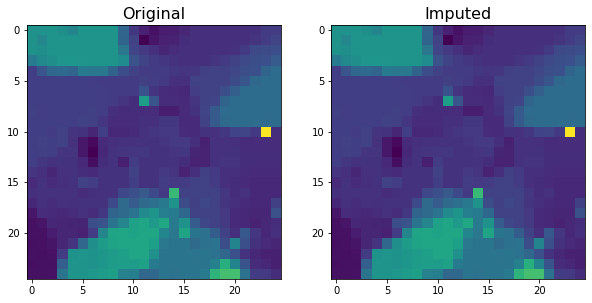

Square : (0, 1)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:04<00:00,  2.16it/s]


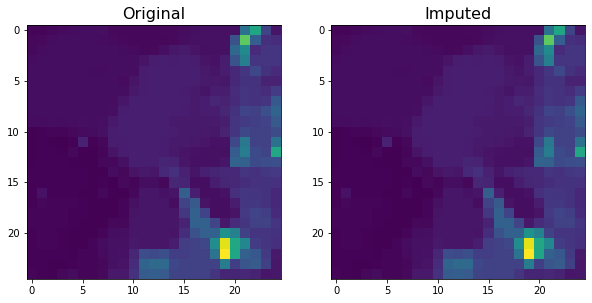

Square : (0, 2)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:13<00:00,  1.89it/s]


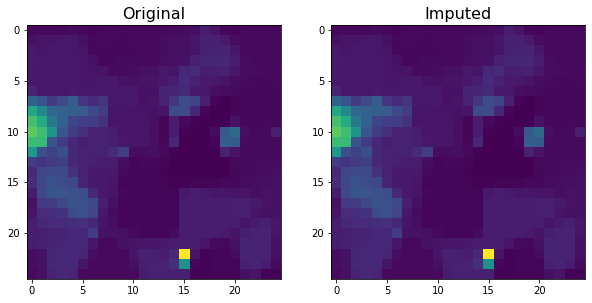

Square : (0, 3)


Epoch(1): D_loss, G_loss ===> 0.030, -0.000: 100%|███████████████████████████████████| 139/139 [01:08<00:00,  2.03it/s]


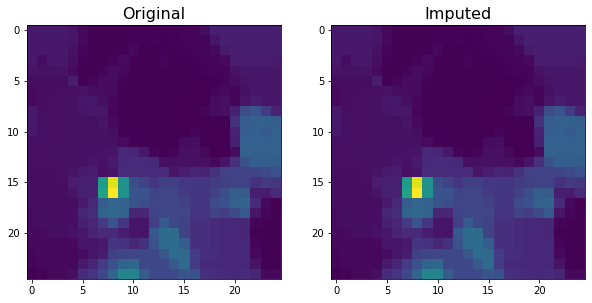

Square : (1, 0)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|████████████████████████████████| 139/139 [1:11:36<00:00, 30.91s/it]


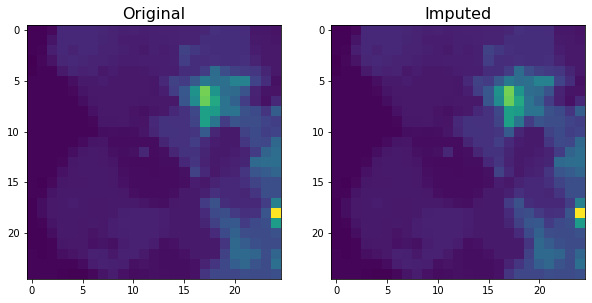

Square : (1, 1)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:15<00:00,  1.83it/s]


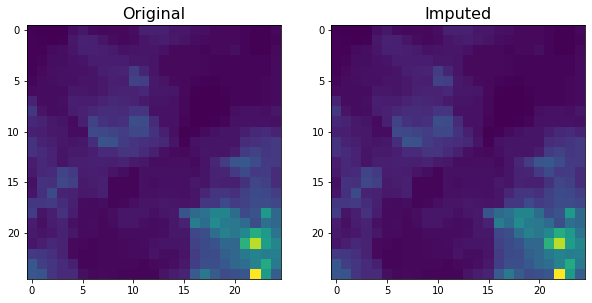

Square : (1, 2)


Epoch(1): D_loss, G_loss ===> 0.022, -0.000: 100%|███████████████████████████████████| 139/139 [01:19<00:00,  1.75it/s]


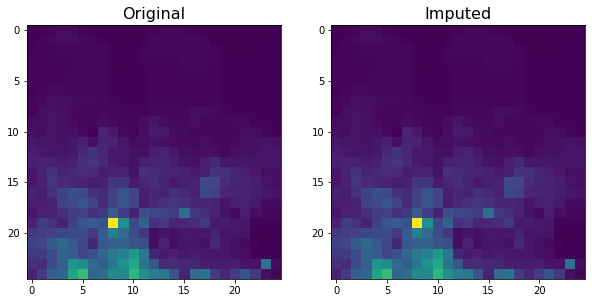

Square : (1, 3)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:29<00:00,  1.55it/s]


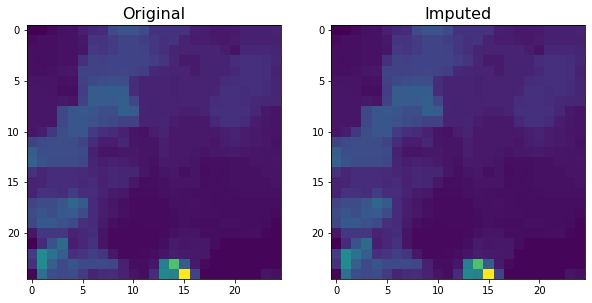

Square : (2, 0)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:14<00:00,  1.87it/s]


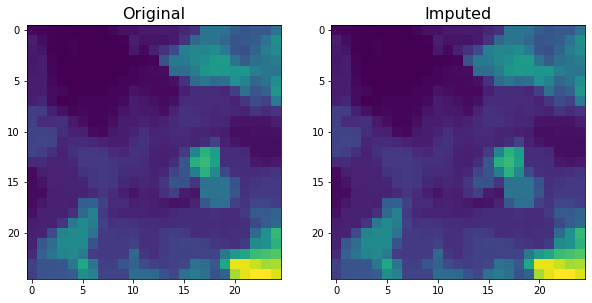

Square : (2, 1)


Epoch(1): D_loss, G_loss ===> 0.041, 0.035: 100%|████████████████████████████████████| 139/139 [01:16<00:00,  1.82it/s]


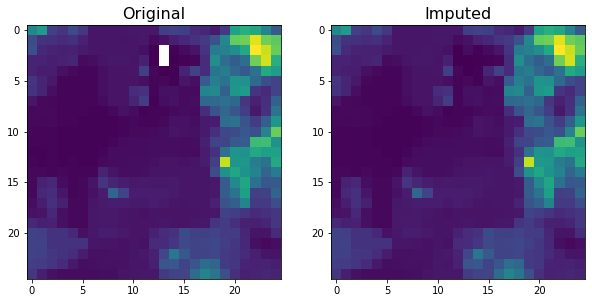

Square : (2, 2)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:16<00:00,  1.83it/s]


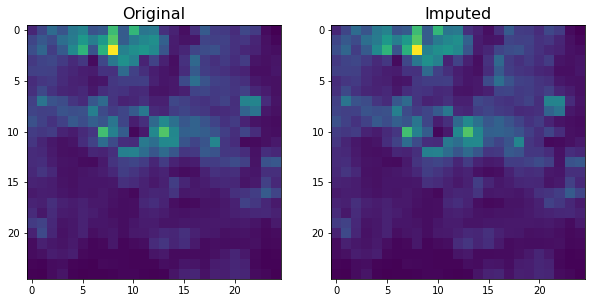

Square : (2, 3)


Epoch(1): D_loss, G_loss ===> 0.001, -0.000: 100%|███████████████████████████████████| 139/139 [01:16<00:00,  1.83it/s]


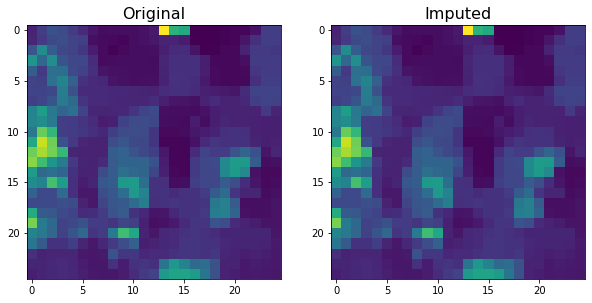

Square : (3, 0)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:22<00:00,  1.69it/s]


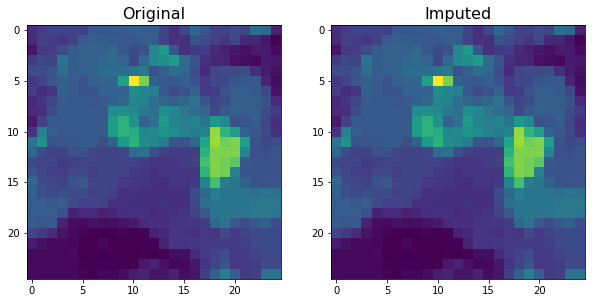

Square : (3, 1)


Epoch(1): D_loss, G_loss ===> 0.000, -0.000: 100%|███████████████████████████████████| 139/139 [01:19<00:00,  1.75it/s]


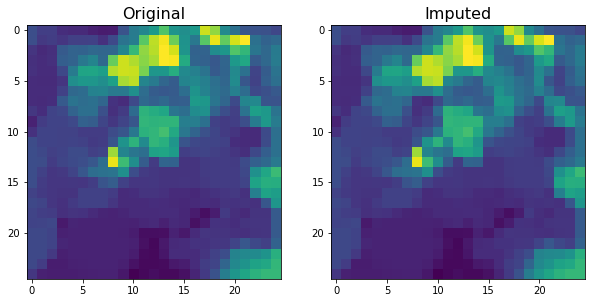

Square : (3, 2)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:16<00:00,  1.81it/s]


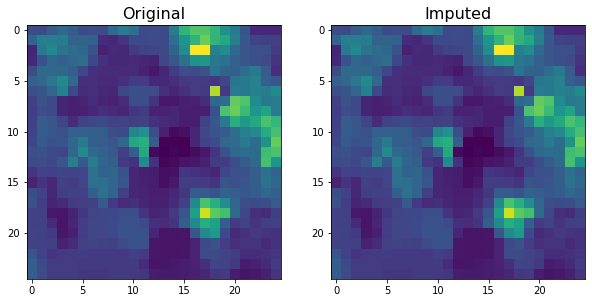

Square : (3, 3)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:15<00:00,  1.85it/s]


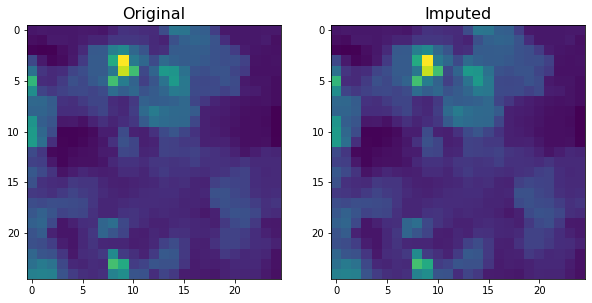

In [267]:
# define the model hyperparameters
conv_gain_parameters = {'batch_size':64,
                        'hint_rate':0.1,
                        'learning_rate':0.001,
                        'alpha':0.005,
                        'iterations':1}
full_data_imputed = full_data_imputaion(full_data=full_data, square_length=25, conv_gain_parameters=conv_gain_parameters)

In [268]:
# output shape
full_data_imputed.shape

(8928, 100, 100, 1)

In [269]:
# Check for nan values
np.isnan(full_data_imputed).max()

False

In [21]:
# save to npy file
# np.save('full_data_imputed.npy', full_data_imputed)
# full_data_imputed = np.load('full_data_imputed.npy')